<a href="https://colab.research.google.com/github/kayanmorshed/BBC-News-Classification-using-LSTM/blob/main/bbc_news_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing necessary libraries

In [2]:
import os
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

## Downloading dataset

First, we download the [BBC News Classification](https://www.kaggle.com/competitions/learn-ai-bbc/data) dataset from Kaggle. Prior to the downloading process, we must ensure that Kaggle is installed in our Colab environment, and we keep `kaggle.json` in the `~/.kaggle/` directory.

In [3]:
! pip install -q kaggle # install kaggle in colab
!rm -r ~/.kaggle # remove any existing .kaggle directory
!mkdir ~/.kaggle # create a new .kaggle directory

After creating the `~/.kaggle/` directory, we upload the `kaggle.json` file downloaded from the Kaggle user account.

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"morshedalam","key":"4d20c1435493d2f8c220f54ffbdc01fb"}'}

And move the `kaggle.json` file into the `~/.kaggle` directory.

In [5]:
!mv ./kaggle.json ~/.kaggle/ # move the kaggle.json file to the newly created directory
!chmod 600 ~/.kaggle/kaggle.json # change permnission
!ls -l ~/.kaggle/kaggle.json

-rw------- 1 root root 67 May  4 21:09 /root/.kaggle/kaggle.json


Now, we have everything in place to start downloading the dataset.

In [6]:
# download the compressed dataset
!kaggle competitions download -c learn-ai-bbc

  0% 0.00/1.85M [00:00<?, ?B/s]
100% 1.85M/1.85M [00:00<00:00, 96.5MB/s]


## Unzipping dataset files

We plan to create a `data` directory before we start unzipping the dataset files. The following code shows the whole unzipping process. 

In [7]:
# create a 'data' directory inside "/content/"
!mkdir /content/data

# remove the zip file after unzipping the files in the 'data' directory
!unzip -q /content/learn-ai-bbc.zip -d /content/data/ 
!rm -r /content/learn-ai-bbc.zip 

mkdir: cannot create directory ‘/content/data’: File exists


Let's check what is inside the `data` directory.

In [8]:
os.listdir('/content/data/')

['BBC News Train.csv',
 'BBC News Sample Solution.csv',
 '.ipynb_checkpoints',
 'BBC News Test.csv']

As we can see, the dataset contains a `train` data file named `BBC News Train.csv` and a `test` data file named `BBC News Test.csv`. 

Now, let's check the structure of both `train` and `test` data file.

In [9]:
# Checking training data
with open("/content/data/BBC News Train.csv", 'r') as csvfile:
    print(f"CSV header:\n {csvfile.readline()}")
    print(f"First data point:\n {csvfile.readline()}")

CSV header:
 ArticleId,Text,Category

First data point:
 1833,worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green li

In [10]:
# Checking testing data
with open("/content/data/BBC News Test.csv", 'r') as csvfile:
    print(f"CSV header:\n {csvfile.readline()}")
    print(f"First data point:\n {csvfile.readline()}")

CSV header:
 ArticleId,Text

First data point:
 1018,qpr keeper day heads for preston queens park rangers keeper chris day is set to join preston on a month s loan.  day has been displaced by the arrival of simon royce  who is in his second month on loan from charlton. qpr have also signed italian generoso rossi. r s manager ian holloway said:  some might say it s a risk as he can t be recalled during that month and simon royce can now be recalled by charlton.  but i have other irons in the fire. i have had a  yes  from a couple of others should i need them.   day s rangers contract expires in the summer. meanwhile  holloway is hoping to complete the signing of middlesbrough defender andy davies - either permanently or again on loan - before saturday s match at ipswich. davies impressed during a recent loan spell at loftus road. holloway is also chasing bristol city midfielder tom doherty.



As you can see, each data point in the training set is composed of:

1. an `ArticleId`
2. the `Text` of the news article, and
3. the `Category` of the article.

And they are separated by commas. 

The `testing` set, however doesn't have any `Category` feature, and it's our job is to determine the most likely category of a given a article from the `test` dataset.

## Setting up hyperparameters 

Now, let's define some hyperparaters that will be used in data preparation and pre-processing tasks.

In [11]:
# the maximum number of words to keep, based on word frequency
NUM_WORDS = 1000

# dimension of the dense embedding that will be used in the embedding layer of the model
EMBEDDING_DIM = 16

# maximum length of all sequences
MAXLEN = 120

# padding strategy 
PADDING = 'post'

# token to replace out-of-vocabulary words during text_to_sequence() calls
OOV_TOKEN = "<OOV>"

# proportion of data used for training
TRAINING_SPLIT = .8

## Loading and pre-processing data

First, let's start with the definiton of the methods to remove stopwords from the training texts.

In [12]:
def remove_stopwords(sentence):
    # list of stopwords
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
    
    # sentence converted to lowercase-only
    sentence = sentence.lower()

    # get all the comma separated words in a list
    word_list = sentence.split()

    # keep all the words which are not stopwords
    words = [w for w in word_list if w not in stopwords]
    
    # reconstruct sentence after discarding all stopwords
    sentence = " ".join(words)

    return sentence

Now, let's define the `parse_data_from_file()` method to load training dataset and extract texts and corresponding categories. 

In [13]:
def parse_data_from_file(filename):
    # lists to include sentences and labels separately
    sentences = []
    labels = []

    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader) # skipping the header row

        for row in reader:
            # add the corresponding category of a news article into the 'labels' list
            labels.append(row[2])

            # add the texts of a news article into the 'sentences' list
            sentence = row[1]
            sentence = remove_stopwords(sentence)
            sentences.append(sentence)

    return sentences, labels

Now, let's call the `parse_data_from_file()` method and check out the detailed information about the training dataset.

In [14]:
# call the parse_data_from_file() with the path of the training set
sentences, labels = parse_data_from_file("/content/data/BBC News Train.csv")

print(f"Number of sentences in the training dataset: {len(sentences)}\n")
print(f"Number of words in the 1st sentence (after removing stopwords). {len(sentences[0].split())}\n")
print(f"Number of labels in the dataset: {len(labels)}\n")
print(f"First 10 labels: {labels[:10]}")

Number of sentences in the training dataset: 1490

Number of words in the 1st sentence (after removing stopwords). 203

Number of labels in the dataset: 1490

First 10 labels: ['business', 'business', 'business', 'tech', 'business', 'politics', 'sport', 'entertainment', 'business', 'entertainment']


## Train & Validation Split

The deep learning model we will use to classify news articles requires the training dataset splitted into: 1) a `train` set, and 2) a `validation` set.

Let's define the `train_val_split()` method to split the training dataset into training and validation sentences and labels given a training split size set as `TRAINING_SPLIT` earlier.


In [15]:
def train_val_split(sentences, labels, training_split):
    # compute the number (an integer) of sentences that will be used for training
    train_size = int(len(sentences) * training_split)

    # split the sentences and labels into train/validation splits
    train_sentences = sentences[0:train_size]
    train_labels = labels[0:train_size]

    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]
 
    return train_sentences, validation_sentences, train_labels, validation_labels

Now, it's time to call the `train_val_split()` method and split the training dataset into train/validation splits.

In [16]:
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"Number of sentences for training: {len(train_sentences)} \n")
print(f"Number of labels for training: {len(train_labels)}\n")
print(f"Number of sentences for validation: {len(val_sentences)} \n")
print(f"Number of labels for validation: {len(val_labels)}")

Number of sentences for training: 1192 

Number of labels for training: 1192

Number of sentences for validation: 298 

Number of labels for validation: 298


## Tokenization: Sequences and Padding

First, we define the `fit_tokenizer()` method to return a `Tokenizer` for us that has been fitted to the training sentences.

In [17]:
def fit_tokenizer(train_sentences, num_words, oov_token):    
    # instantiate the Tokenizer class
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
    
    # fit the tokenizer to the training sentences
    tokenizer.fit_on_texts(train_sentences)
    
    return tokenizer

Now, let's call the `fit_tokenizer()` method to fit the `Tokenizer` to the training sentences.

In [18]:
# fit the Tokenizer
tokenizer = fit_tokenizer(train_sentences, NUM_WORDS, OOV_TOKEN)

# get word_index
word_index = tokenizer.word_index

print(f"Number of words in the vocabulary: {len(word_index)}\n")

Number of words in the vocabulary: 22647



Since we already tokenize the traning sentences, now, let's define and run the following `seq_and_pad()` method to convert each text data point into its padded sequence representation.

In [19]:
def seq_and_pad(sentences, tokenizer, padding, maxlen):       
    # convert training sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)
    
    # pad the sequences using the correct padding and maxlen
    padded_sequences = pad_sequences(sequences, 
                                     maxlen=maxlen, 
                                     padding=padding, 
                                     truncating='post')
    
    return padded_sequences

Run the `seq_and_pad()` method and get the padded training sequences.

In [20]:
train_padded_seq = seq_and_pad(train_sentences, tokenizer, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(val_sentences, tokenizer, PADDING, MAXLEN)

print(f"Shape of padded training sequences: {train_padded_seq.shape}\n")
print(f"Shape of padded validation sequences: {val_padded_seq.shape}")

Shape of padded training sequences: (1192, 120)

Shape of padded validation sequences: (298, 120)


Finally, we need to tokenize the labels. Let's define the `tokenize_labels()` method to achieve our goal.

In [21]:
def tokenize_labels(all_labels, split_labels):    
    # instantiate the Tokenizer
    label_tokenizer = Tokenizer()
    
    # fit the tokenizer on all the labels
    label_tokenizer.fit_on_texts(all_labels)

    '''
    Note: we should fit the tokenizer to all the labels to avoid 
    the case of a particular label not being present in the validation set
    '''

    # convert labels to sequences
    label_seq = label_tokenizer.texts_to_sequences(split_labels)
    
    # convert sequences to a numpy array. 
    # note: we substact 1 from every entry in the array because 
    # Tokenizer yields values that start at 1 rather than at 0
    label_seq_np = np.array(label_seq)-1

    return label_seq_np

Call the `tokenizer_labels()` method to tokenize the labels and convert into numpy arrays.

In [22]:
train_label_seq = tokenize_labels(labels, train_labels)
val_label_seq = tokenize_labels(labels, val_labels)

print(f"Shape of tokenized labels of the training set: {train_label_seq.shape}\n")
print(f"Shape of tokenized labels of the validation set: {val_label_seq.shape}\n")
print(f"First 5 labels of the training set:\n{train_label_seq[:5]}\n")
print(f"First 5 labels of the validation set:\n{val_label_seq[:5]}\n")

Shape of tokenized labels of the training set: (1192, 1)

Shape of tokenized labels of the validation set: (298, 1)

First 5 labels of the training set:
[[1]
 [1]
 [1]
 [4]
 [1]]

First 5 labels of the validation set:
[[3]
 [3]
 [2]
 [1]
 [4]]



## Text classification model

Our training data is already prepared to be fed into a deep neural network that will work as a text classifier to classify each news article as part of being a certain category. 

Now, it's time to define our model. Let's define the model architecture by completing the following `model()` method.

In [28]:
def model(num_words, embedding_dim, maxlen, lstm1_dim, lstm2_dim, num_categories):
    tf.random.set_seed(123)
    
    model = tf.keras.Sequential([ 
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm1_dim, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm2_dim)),
        tf.keras.layers.Dense(num_categories, activation='softmax')
    ])
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']) 

    return model

Before generating the model using `model()`, let's find out how many unique categories the training dataset have.

In [24]:
num_unique_categories = np.unique(labels)
print(f'Number of unique categories in the training dataset: {len(num_unique_categories)}')

Number of unique categories in the training dataset: 5


Now, let's create the model first.

In [29]:
# set LSTM dimensions
lstm1_dim = 32
lstm2_dim = 16

# create the model
model = model(NUM_WORDS, EMBEDDING_DIM, MAXLEN, lstm1_dim, lstm2_dim, len(num_unique_categories))

print(f'\nModel Summary: {model.summary()}')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           16000     
                                                                 
 bidirectional_2 (Bidirectio  (None, 120, 64)          12544     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 39,077
Trainable params: 39,077
Non-trainable params: 0
_________________________________________________________________

Model Summary: None


And train the model with prepared training datasets.

In [30]:
# train the model
history = model.fit(train_padded_seq, train_label_seq, epochs=30, validation_data=(val_padded_seq, val_label_seq))

Epoch 1/30
38/38 [==============================] - 20s 294ms/step - loss: 1.5957 - accuracy: 0.2357 - val_loss: 1.5814 - val_accuracy: 0.2013
Epoch 2/30
38/38 [==============================] - 9s 250ms/step - loss: 1.3992 - accuracy: 0.3482 - val_loss: 1.2496 - val_accuracy: 0.4966
Epoch 3/30
38/38 [==============================] - 8s 211ms/step - loss: 1.2527 - accuracy: 0.4673 - val_loss: 1.2724 - val_accuracy: 0.3758
Epoch 4/30
38/38 [==============================] - 10s 248ms/step - loss: 1.1001 - accuracy: 0.4933 - val_loss: 1.1029 - val_accuracy: 0.5503
Epoch 5/30
38/38 [==============================] - 9s 240ms/step - loss: 0.9384 - accuracy: 0.5889 - val_loss: 0.9557 - val_accuracy: 0.6342
Epoch 6/30
38/38 [==============================] - 8s 205ms/step - loss: 0.7589 - accuracy: 0.7257 - val_loss: 0.9338 - val_accuracy: 0.6275
Epoch 7/30
38/38 [==============================] - 9s 238ms/step - loss: 0.5764 - accuracy: 0.7886 - val_loss: 0.7055 - val_accuracy: 0.6678
Epoc

## Evaluating Model Training

Now, let check how the model performed during the training process. 

In [31]:
def evaluate_model(history):
    # Check how accracy and loss changes over the training epochs

    epoch_accuracy = history.history['accuracy']
    epoch_val_accuracy = history.history['val_accuracy']
    epoch_loss = history.history['loss']
    epoch_val_loss = history.history['val_loss']
    
    plt.figure(figsize=(20, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, len(epoch_accuracy)), epoch_accuracy, 'b-', linewidth=2, label='Training Accuracy')
    plt.plot(range(0, len(epoch_val_accuracy)), epoch_val_accuracy, 'r-', linewidth=2, label='Validation Accuracy')
    plt.title('Training & validation accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(range(0, len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Training Loss')
    plt.plot(range(0, len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Validation Loss')
    plt.title('Training & validation loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.show()

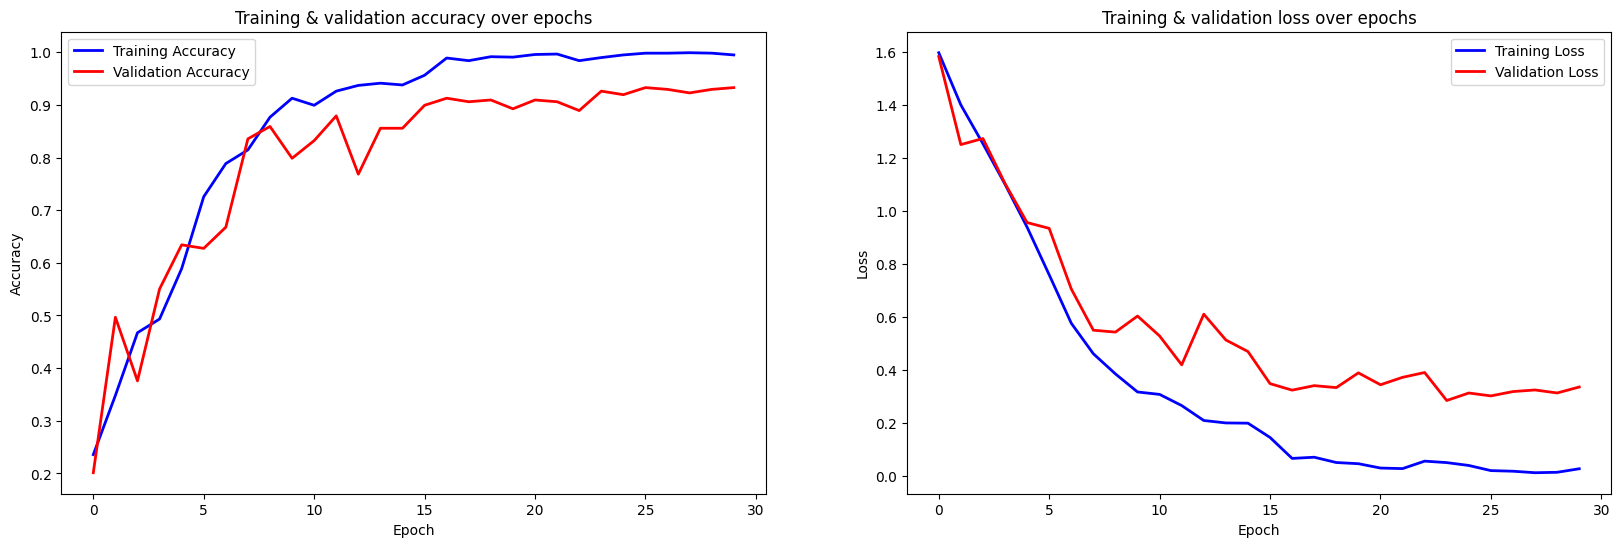

In [32]:
# check how accuract & loss changes over epochs during the training process
evaluate_model(history)

## Prediction

Now that our model is successfully trained, let's check how it performs for the test prediction tasks. Before performing prediction task, we need to preprocess our test dataset.

Let's start with the removal of stopwords from test dataset first.

In [35]:
def parse_test_data_from_file(filename):
    # lists to include texts from articles
    test_sentences = []

    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader) # skipping the header row

        for row in reader:
            # add the texts of a news article into the 'test_sentences' list
            sentence = row[1]
            sentence = remove_stopwords(sentence)
            test_sentences.append(sentence)

    return test_sentences

# call the parse_test_data_from_file() method with the path of the testing set
test_sentences = parse_test_data_from_file("/content/data/BBC News Test.csv")

print(f"Number of sentences in the test dataset: {len(test_sentences)}\n")
print(f"Number of words in the 1st sentence (after removing stopwords). {len(test_sentences[0].split())}\n")

Number of sentences in the test dataset: 735

Number of words in the 1st sentence (after removing stopwords). 98



After removing stopwords from the test dataset, we must convert the sentences to the token sequences and later to the padded sequences. We can use the same `fit_tokenizer()` and `seq_and_pad()` methods we used for training dataset to achieve our goal here.

In [36]:
# fit the Tokenizer for the test dataset
test_tokenizer = fit_tokenizer(test_sentences, NUM_WORDS, OOV_TOKEN)

# get word_index
test_word_index = test_tokenizer.word_index

test_padded_seq = seq_and_pad(test_sentences, test_tokenizer, PADDING, MAXLEN)

print(f"Number of words in the test vocabulary: {len(test_word_index)}\n")
print(f"Shape of padded training sequences: {test_padded_seq.shape}\n")

Number of words in the test vocabulary: 18598

Shape of padded training sequences: (735, 120)



#### Now, let's make prediction on the test dataset.

In [37]:
# make predictions (categories) on the test data
predictions = model.predict(test_padded_seq)

23/23 [==============================] - 3s 46ms/step


In [47]:
# Get the class with the highest probability for each input sentence
predicted_classes = predictions.argmax(axis=1)
print(f'Predicted classes:\n\n {predicted_classes}')

Predicted classes:

 [4 0 3 1 2 3 4 1 3 3 4 1 2 2 1 0 1 3 4 0 3 1 2 1 4 3 2 3 4 2 4 4 1 4 3 3 4
 4 3 4 2 0 4 2 4 4 1 4 2 1 1 1 0 0 4 3 1 1 4 0 2 0 4 2 0 3 3 3 2 2 2 4 1 3
 4 1 4 3 2 3 3 2 4 4 4 0 2 3 2 3 1 2 2 0 3 1 2 4 1 3 1 1 4 3 2 3 3 4 3 4 0
 3 0 3 3 2 4 3 2 1 3 1 0 4 0 2 2 4 3 3 3 2 2 1 2 2 3 2 2 3 4 3 3 3 4 3 4 0
 4 1 1 3 4 0 1 1 1 4 4 2 4 0 1 0 1 0 4 0 4 3 0 3 3 3 4 1 4 3 1 0 4 4 4 3 0
 4 3 2 1 4 0 3 4 4 2 3 3 0 0 1 2 0 1 3 2 4 2 4 3 2 2 2 3 3 4 3 1 4 2 3 2 3
 3 4 4 0 3 4 2 4 2 3 4 2 0 0 0 4 3 4 1 0 1 4 3 2 2 2 1 4 2 2 4 0 4 4 3 0 1
 0 2 1 0 0 3 2 0 4 4 3 3 2 1 2 0 1 2 3 3 2 1 4 3 1 3 3 2 0 3 3 2 1 4 1 2 0
 0 4 0 0 1 3 2 2 4 4 4 3 0 4 4 4 2 2 0 4 0 2 4 3 4 0 4 4 1 1 4 1 0 4 3 4 3
 4 1 2 1 4 4 1 3 4 3 4 0 3 0 1 3 1 2 1 1 3 4 1 1 3 3 1 3 3 2 1 1 0 3 0 3 4
 1 2 3 2 4 1 4 4 3 2 0 4 4 2 4 2 3 4 3 4 3 2 0 3 2 4 0 2 2 4 2 0 3 0 3 4 4
 4 2 4 4 3 1 2 0 4 3 3 3 4 3 2 1 0 4 0 1 2 2 3 0 4 4 0 3 4 4 3 2 1 0 4 4 4
 4 0 0 2 2 4 1 2 3 2 2 3 3 3 1 4 1 4 3 4 2 4 2 3 3 2 1 2 2 2 1 3 4 1 4 4 2
 0 4